## Importing Modules

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('/home/junhokang/script')
import scjp

2021-12-29 13:52:52.194467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-29 13:52:52.194506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# useful imports
import numpy as np
import scipy as scipy
import scanpy as sc
import scanpy.external as sce
import pandas as pd
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', None)
import pickle as pkl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,8]
import seaborn as sns
from collections import defaultdict, Counter
import networkx as nx
import igraph, re, glob
from bbknn import bbknn
from geosketch import gs
import scrublet as scr
import joblib as jl
from datetime import datetime
def timestamp():
    return datetime.now().strftime("%y%m%d%H%M")
import logging
import scipy.stats
from SCCAF import *

In [3]:
# setting scanpy
%matplotlib inline
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, color_map='OrRd')
sc.logging.print_version_and_date()

Running Scanpy 1.8.1, on 2021-12-29 13:52.


In [4]:
nb_name = 'CART07.v02.HCA_Cancer_BBKNN2_211116'
version = '.'.join(nb_name.split('.')[:2])+'.'
data = '_'.join(nb_name.split('.')[-1:][0].split('_')[:-2])
print('Version:', version)
print('Data:', data)

Version: CART07.v02.
Data: HCA_Cancer


In [5]:
base_folder = '/home/junho/links/single_cell_rnaseq/'

## Loading Adata

In [6]:
adata = sc.read('../hca_cancer_merge/CART07.v02.hca_cancer_merge_sketch2_211116.h5ad')

Only considering the two last: ['.hca_cancer_merge_sketch2_211116', '.h5ad'].
Only considering the two last: ['.hca_cancer_merge_sketch2_211116', '.h5ad'].


In [7]:
adata

AnnData object with n_obs × n_vars = 374005 × 36601
    obs: 'Author', 'Organ', 'Organ_Specific', 'CellType_original', 'Batch', 'CellType', 'Method', 'name'

## Remove Testis data

In [8]:
adata = adata[adata.obs['Organ']!='Testis']

In [9]:
adata

View of AnnData object with n_obs × n_vars = 367806 × 36601
    obs: 'Author', 'Organ', 'Organ_Specific', 'CellType_original', 'Batch', 'CellType', 'Method', 'name'

In [11]:
{a:b for a,b in zip(adata.obs['Author'],adata.obs['Organ'])}

{'vieira19_Alveoli_and_parenchyma_anonymised': 'Lung',
 'madissoon19_lung': 'Lung',
 'baron16': 'Pancreas',
 'henry18_0': 'Prostate',
 'james20': 'Colon',
 'macparland18': 'Liver',
 'stewart19_adult': 'Kidney',
 'voigt19': 'Retina',
 'menon19': 'Retina',
 'wang20_colon': 'Colon',
 'wang20_ileum': 'Ileum',
 'wang20_rectum': 'Rectum',
 'tucker20_heart': 'Heart',
 'HQ.Dinh': 'Fallopian_tube',
 'pal20_breast': 'Breast',
 'Ankur_Sharma': 'Liver_Cancer',
 'Lichun.Ma': 'Liver_Cancer',
 'OH.Lee': 'Colon_Cancer',
 'Junbin.Qian': 'Breast_Cancer',
 'Qian': 'Colon_Cancer',
 'di.Magliano.MP': 'Pancreas_Cancer',
 'Sun.BaoFa': 'Pancreas_Cancer',
 'Sunny.Z.Wu': 'Breast_Cancer'}

In [ ]:
before = sc.read('../hca_cancer_merge/CART06.v02.hca_cancer_merge_bbknn2_ns.h5ad')

Only considering the two last: ['.hca_cancer_merge_bbknn2_ns', '.h5ad'].
Only considering the two last: ['.hca_cancer_merge_bbknn2_ns', '.h5ad'].


In [15]:
before = before[before.obs['Organ']!='Testis']

In [ ]:
before

In [17]:
Counter(before.obs['Organ'])

Counter({'Lung': 28821,
         'Pancreas': 7714,
         'Prostate': 14688,
         'Colon': 20090,
         'Liver': 8444,
         'Kidney': 14115,
         'Retina': 18022,
         'Ileum': 5980,
         'Rectum': 3797,
         'Heart': 16236,
         'Fallopian_tube': 4715,
         'Breast': 18369,
         'Liver_Cancer': 41629,
         'Ovary_Cancer': 16606,
         'Lung_Cancer': 35420,
         'Colon_Cancer': 36163,
         'Pancreas_Cancer': 52468,
         'Breast_Cancer': 47370})

## BBKNN2, Not Scaled Data

In [13]:
scjp.jhk.ad_summary(adata)

         max      mean  min  len_obs  len_var
0  21.731197  0.078275  0.0   367806    36601


In [15]:
num = dict(Counter(adata.obs['Batch']))

In [16]:
for f in num.items():
    if f[1]<3:
        print(f[0])

MUX7497


In [19]:
adata = adata[adata.obs['Batch']!='MUX7497']

In [20]:
adata

View of AnnData object with n_obs × n_vars = 367804 × 36601
    obs: 'Author', 'Organ', 'Organ_Specific', 'CellType_original', 'Batch', 'CellType', 'Method', 'name'

In [21]:
ndata_ns = scjp.regress_iter(adata,['Method'],['CellType'],'Batch',scale=False)
# (adata, #to regress out, #to keep, 'Batch')

fitting linear model...
correcting batch...
running pca...
computing PCA
    with n_comps=50
    finished (0:07:48)
running bbknn...
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:52:41)


In [22]:
# Not scaled Data
scjp.sc_process(ndata_ns,pid = 'u')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:23:33)


AnnData object with n_obs × n_vars = 367804 × 36601
    obs: 'Author', 'Organ', 'Organ_Specific', 'CellType_original', 'Batch', 'CellType', 'Method', 'name'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [23]:
ndata_ns

AnnData object with n_obs × n_vars = 367804 × 36601
    obs: 'Author', 'Organ', 'Organ_Specific', 'CellType_original', 'Batch', 'CellType', 'Method', 'name'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

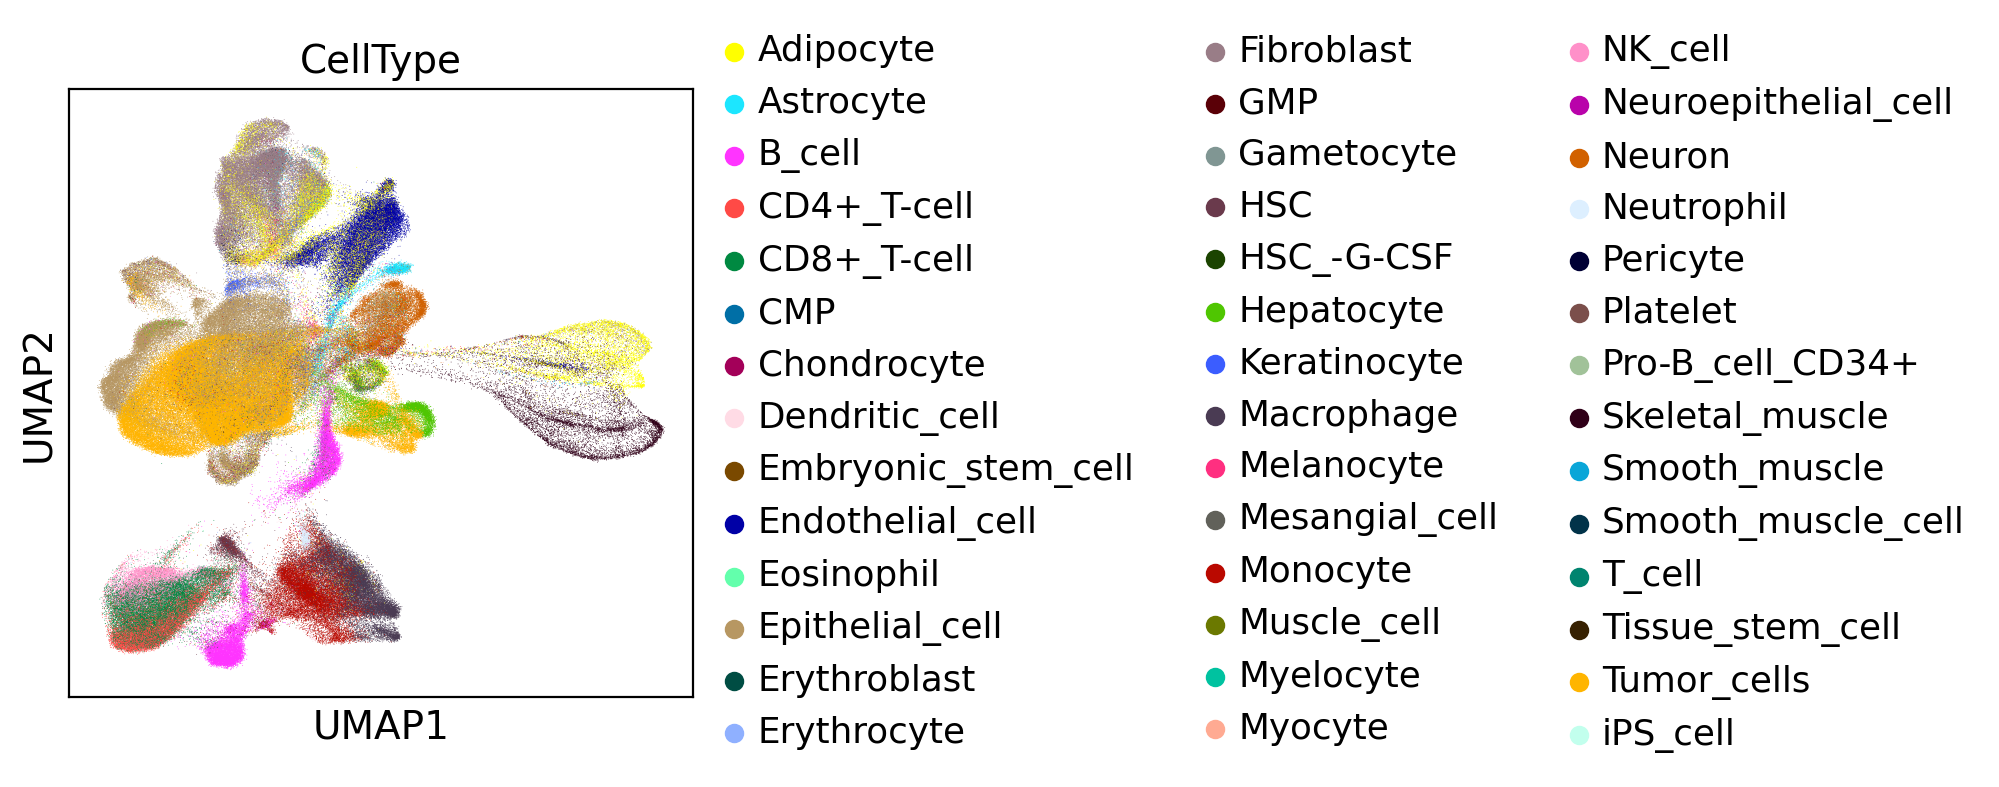

In [24]:
scjp.us(ndata_ns,'CellType')

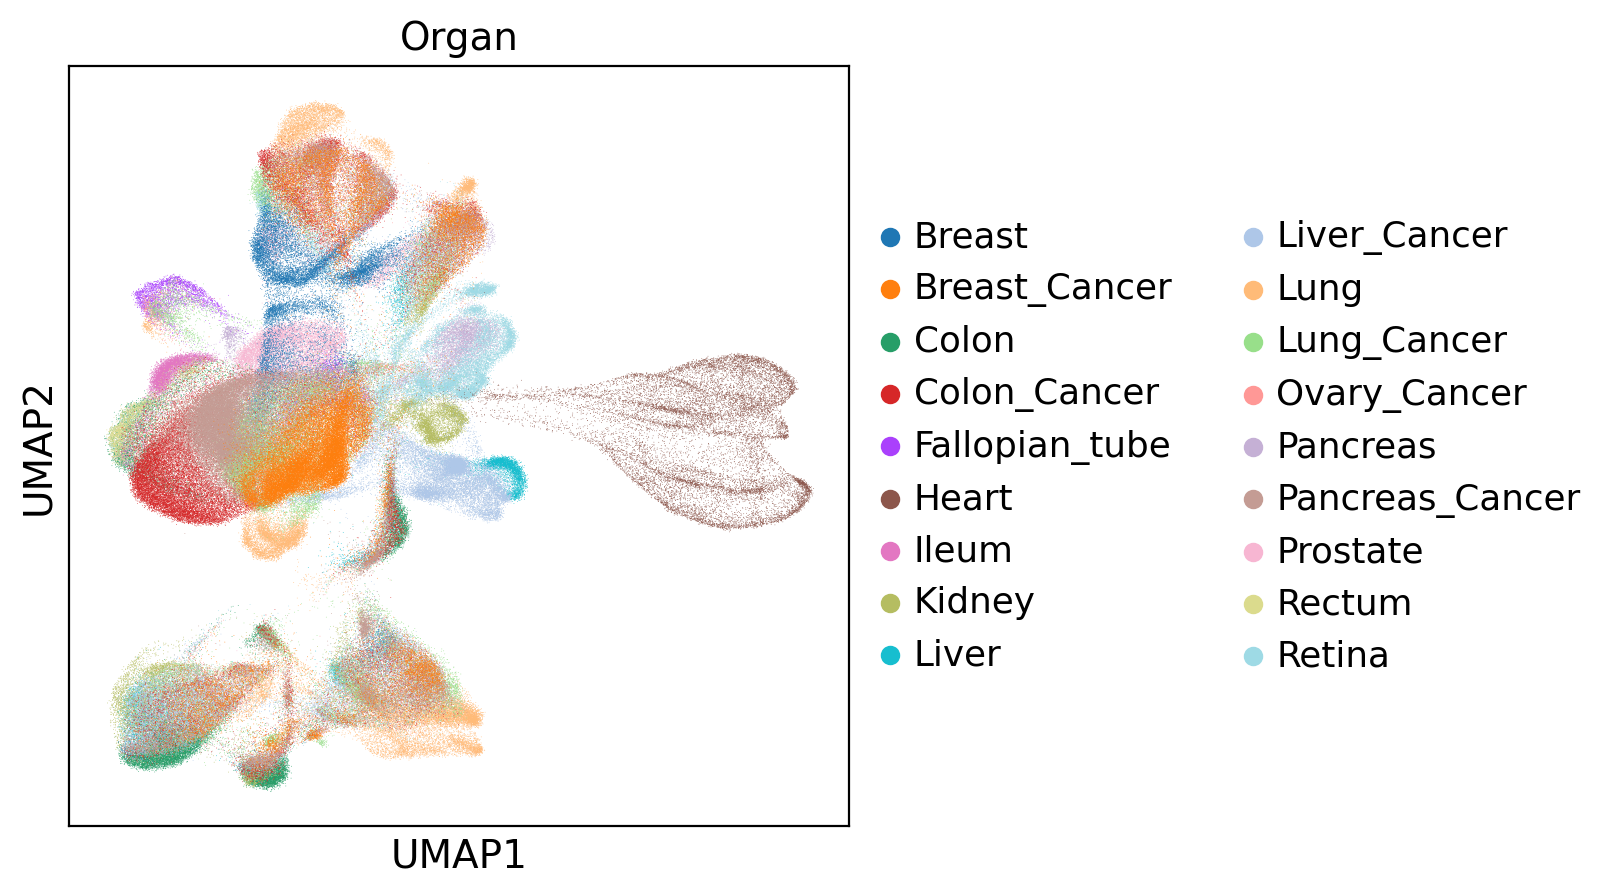

In [25]:
scjp.us(ndata_ns,'Organ')

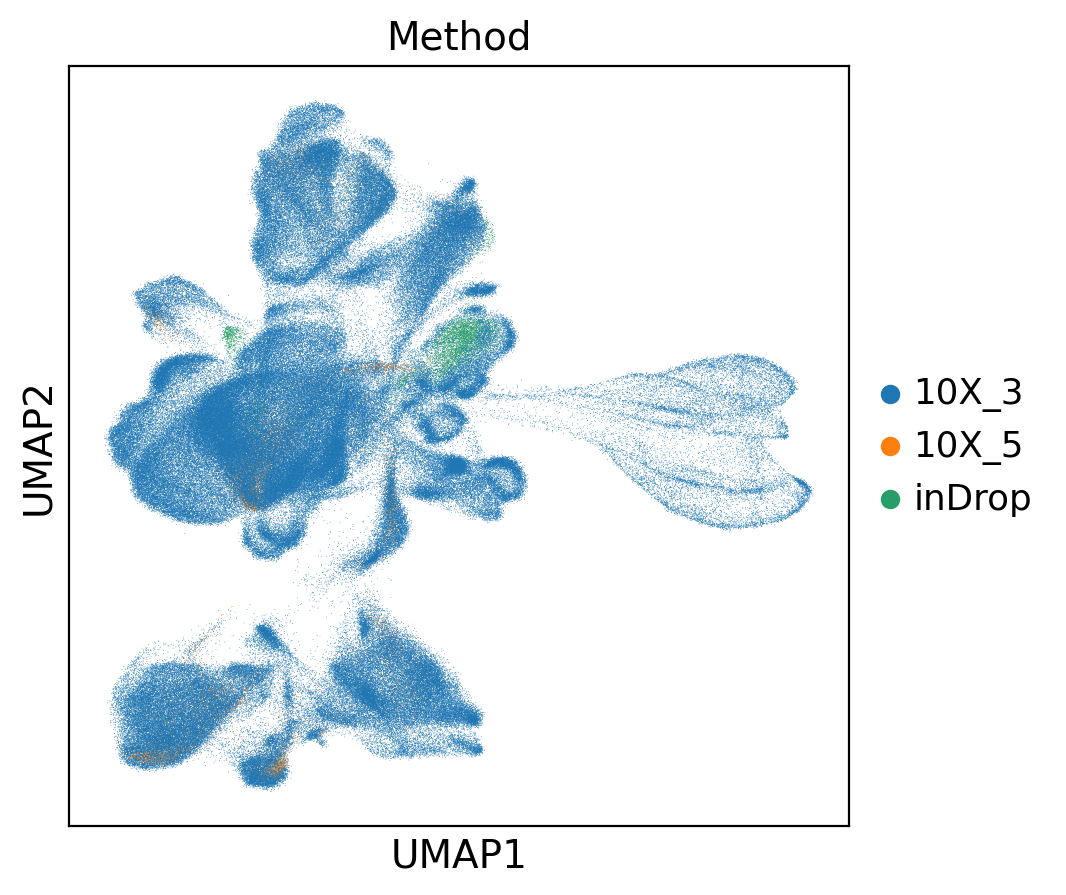

In [26]:
scjp.us(ndata_ns,'Method')

In [27]:
ndata_ns.raw = adata

In [38]:
ndata_ns.write('../hca_cancer_merge/%s%s.h5ad'%(version, 'hca_cancer_merge_bbknn2_ns_211117'))